Shell for the functions needed for the gpt model

In [154]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax import struct
from flax.training import train_state
import optax
import math
from tqdm.auto import tqdm
import tiktoken
import matplotlib.pyplot as plt
from flax.training.early_stopping import EarlyStopping

key = jax.random.PRNGKey(42)

In [155]:
# Hyperparameters
batch_size = 4
context_length = 8
train_test_split_size = 0.9
embed_dim = 32
head_num = 2
dim_mul = 4
block_layers = 2
learning_rate = 3e-4
max_iters = 1000

In [156]:
def open_data(path: str = "./new_nietzsche.txt"):
    txt = open(path, "r", encoding="utf-8").read()
    return txt

text = open_data()

In [157]:
class Tokenizer:
    """
    Class that takes care of encoding and decoding the text
    """

    def __init__(self, text: str, tokenizer_type: str = "base") -> None:
        self.tokenizer_type = tokenizer_type

        if self.tokenizer_type == "base":
            self.vocab_size, self.all_characters = self.sort_characters(text)
        elif self.tokenizer_type == "gpt-4o":
            self.enc = tiktoken.encoding_for_model("gpt-4o")
            self.vocab_size = self.enc.n_vocab

    def get_vocab_size(self):
        return int(jnp.copy(self.vocab_size))

    def sort_characters(self, data):
        all_characters = sorted(list(set(data)))
        vocab_size = len(all_characters)

        return vocab_size, all_characters

    def encode(self, text):
        encoded_text = []
        if self.tokenizer_type == "base":
            for c in text:
                num = self.all_characters.index(c)
                encoded_text.append(num)
        elif self.tokenizer_type == "gpt-4o":
            encoded_text = self.enc.encode(text)
        return jnp.array(encoded_text)

    def decode(self, encoded_text):
        text = []
        if self.tokenizer_type == "base":
            for n in encoded_text:
                char = self.all_characters[n]
                text.append(char)
            text = "".join([str(item) for item in text])

        elif self.tokenizer_type == "gpt-4o":
            text = self.enc.decode(encoded_text)

        return text

In [158]:
tokenizer = Tokenizer(text=text, tokenizer_type="gpt-4o") 
all_data = tokenizer.encode(text)
tokenizer.get_vocab_size()

200019

In [159]:
# test tokenizer
print(tokenizer.decode(all_data[:100]))

What I am now going to relate is the history of the next two centuries.
I shall describe what will happen, what must necessarily happen:
the triumph of Nihilism. This history can be written already; for
necessity itself is at work in bringing it about. This future is
already proclaimed by a hundred different omens; as a destiny it
announces its advent everywhere, for this music of to-morrow all ears
are already pricked. The whole of our culture


In [160]:
class BatchLoader:
    def __init__(self, data, train_test_split_size, key) -> None:
        self.training_data, self.validation_data = self.splitting_data(
            data, train_test_split_size
        )
        self.key = key

    def splitting_data(self, data, split_size):
        n = int(split_size * len(data))
        training_data = data[:n]
        validation_data = data[n:]
        return training_data, validation_data

    def get_batch(self, batch_size, context_length, training: bool = True):
        train_batches = []
        target_batches = []

        if training:
            b_data = self.training_data
        else:
            b_data = self.validation_data

        for _ in range(batch_size):
            self.key, subkey = jax.random.split(self.key)
            pos = jax.random.randint(
                key=subkey, shape=(), minval=0, maxval=(len(b_data) - context_length)
            )
            batch_data = b_data[pos : pos + context_length]
            train_batches.append(batch_data)
            batch_data = b_data[pos + 1 : pos + context_length + 1]
            target_batches.append(batch_data)

        train_batches = jnp.stack(train_batches)
        target_batches = jnp.stack(target_batches)

        return train_batches, target_batches

In [161]:
batch_loader = BatchLoader(data=all_data, train_test_split_size=train_test_split_size, key=key)
train, targets = batch_loader.get_batch(batch_size, context_length, training=True)
print(train)
print(targets)

[[    11  80146     11   9224   7299  17239    198   5429]
 [ 60967    375  13347    853    501    316    621    483]
 [   483   1118    290 112749 147540  14312   1118  24384]
 [ 18005    306   1039    198  57274    326  15620   1626]]
[[ 80146     11   9224   7299  17239    198   5429    480]
 [   375  13347    853    501    316    621    483  28735]
 [  1118    290 112749 147540  14312   1118  24384    540]
 [   306   1039    198  57274    326  15620   1626    316]]


In [162]:
class SingleAttentionHead(nn.Module):
    embed_dim: int
    head_size: int

    def setup(self):
        self.key = nn.Dense(self.head_size, use_bias=False) 
        self.query = nn.Dense(self.head_size, use_bias=False)
        self.value = nn.Dense(self.head_size, use_bias=False)
        self.dropout = nn.Dropout(rate=0.2)

    def __call__(self, data, training):
        
        k = self.key(data)  # from embed_dim to head_size (B,T,C)
        q = self.query(data) # from embed_size to head_size (B,T,C)
        v = self.value(data) # from embed_size to head_size (B,T,C)

        weights = jnp.matmul(q,jnp.swapaxes(k, -2,-1)) / math.sqrt(self.head_size) # (B,T,T)
        
        #Lower triangular mask matrix of the size B, T, C (same btw as attention)
        mask = jnp.tril(weights)
        
        # for every zero, make it to -inf 
        weights = nn.softmax(jnp.where(mask == 0, -9e16, weights), axis=-1) # axis=-1 since we only want to softmax for each row of T not for the whole data as a whole
        
        weights = self.dropout(weights, deterministic = not training)

        attention = jnp.matmul(weights, v) # (B,T,C)

        return attention

In [163]:
class MultiHeadAttention(nn.Module):
    """
    Multiple attention heads combined together
    """

    head_num: int
    embed_dim: int

    def setup(self):
        self.heads = [
            SingleAttentionHead(
                embed_dim=self.embed_dim, head_size=self.embed_dim // self.head_num
            )
            for _ in range(self.head_num)
        ]
        self.think = nn.Dense(self.embed_dim, use_bias=False)
        self.dropout = nn.Dropout(rate=0.2)

    def __call__(self, data, training):
        multiple_attentions = jnp.concatenate(
            [head(data, training) for head in self.heads], axis=-1
        )
        thoughts = self.think(multiple_attentions)
        out = self.dropout(thoughts, deterministic = not training)
        return out

In [164]:
class FeedForward(nn.Module):
    '''Simple Feed Forward NN that goes from embed_dim to a higher dimension and then back to embed_dim'''
    
    embed_dim: int
    dim_mul: int

    def setup(self):
        #this is the heavy thinking part of the model, where it tries to make sense of what was learned
        # in the attention cycle lol
        self.layer1 = nn.Dense(features=(dim_mul*embed_dim), use_bias=False)
        self.layer2 = nn.Dense(features=embed_dim, use_bias=False)
        self.dropout = nn.Dropout(rate=0.2)

    def __call__(self, data, training: bool):
        x = data
        x = self.layer1(x)
        x = nn.relu(x)
        x = self.layer2(x)
        x = self.dropout(x, deterministic = not training)
        return x

In [165]:
class Block(nn.Module):
    '''One run through a block, which consists of MultiheadAttention + Feedforward + Layer Normalisation'''
    dim_mul: int
    embed_dim: int
    head_num: int
    
    def setup(self):
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.multihead = MultiHeadAttention(head_num = self.head_num, embed_dim=self.embed_dim)
        self.feedforward = FeedForward(embed_dim=self.embed_dim, dim_mul=self.dim_mul)
    
    def __call__(self, data, training: bool):
        x = data
        x = x + self.multihead(self.norm1(x), training)
        x = x + self.feedforward(self.norm2(x), training)

        return x

In [166]:
class CustomSequential(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x, *args, **kwargs):
        for layer in self.layers:
            x = layer(x, *args, **kwargs)
        return x

In [167]:
class TransformerModel(nn.Module):
    vocab_size: int
    context_length: int 
    embed_dim: int
    head_num: int
    dim_mul: int
    block_layers: int
    
    def setup(self):
        self.token_embedding_table = nn.Embed(self.vocab_size, self.embed_dim)
        self.position_embedding_table = nn.Embed(
            self.context_length, self.embed_dim
        ) 
        #########################
        self.blocks = CustomSequential([
            Block(head_num=self.head_num, embed_dim=self.embed_dim, dim_mul=self.dim_mul)
            for _ in range(self.block_layers)
        ])
        
        #########################
        self.norm = nn.LayerNorm()
        self.linear = nn.Dense(self.vocab_size, use_bias=False)

    def __call__(self, data, training: bool = True):
        
        
        _, context_length = data.shape
        
        token = self.token_embedding_table(data)
        position = self.position_embedding_table(jnp.arange(context_length))
        
        embedded_data = token + position

        iteration_data = self.blocks(embedded_data, training) # data after one iteration MH,FF (4,8,32)
        data_normalized = self.norm(iteration_data)
        final_data = self.linear(data_normalized)

        return final_data
    
    def generate(self, key, params, data, length):
        
        for i in range(length):
            key, subkey = jax.random.split(key)  # Every character has to be different
            
            data_to_use = data[:, -self.context_length:]
            
            logits = self.apply({"params": params}, data_to_use, training=False)
            logits = logits[:, -1, :]
            
            probabilities = jax.nn.softmax(logits)
            probabilities = jnp.squeeze(probabilities)
            
            next_token = jax.random.choice(subkey, jnp.arange(self.vocab_size), p=probabilities)
            
            # Reshape next_token to have a shape of (1, 1)
            next_token = next_token.reshape((1, 1))
            data = jnp.concatenate((data, next_token), axis=1)

        return data


In [168]:
# Optimizer
scheduler = optax.warmup_cosine_decay_schedule(
    init_value=0.01, peak_value=1, warmup_steps=100, decay_steps=2000
)
#optimizer = optax.adamw(scheduler)

optimizer = optax.adamw(learning_rate=2e-4)

In [183]:
@jax.jit  # Jit the function for efficiency
def _train_step(state, batch, dropout_key):
    dropout_key, dropout_train_key = jax.random.split(dropout_key)
    
    def loss_fn(params):
        
        data, labels = batch
                
        # Same as model.apply
        logits = state.apply_fn( 
            {"params": params},
            data,
            training = True,
            rngs={'dropout': dropout_train_key}
        )

        loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
        mean_loss = jnp.mean(loss)
        
        return mean_loss, logits

    # Gradient function
    grad_fn = jax.value_and_grad(
        loss_fn,  # Function to calculate the loss
        has_aux=True,  # Function has additional outputs, here accuracy
    )
    # Determine gradients for current model, parameters and batch
    (loss, logits), grads = grad_fn(state.params)


    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss


@jax.jit  # Jit the function for efficiency
def _eval_step(state, batch):
    data, labels = batch
    logits = state.apply_fn({"params": state.params}, 
                            data, 
                            training = False)
    
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    mean_loss = jnp.mean(loss)

    
    return mean_loss    


def train(state, num_epochs, dropout_key):
    train_losses = []
    eval_losses = []
    diverging = 0
    
    for epoch in tqdm(range(num_epochs+1)):
        train, train_labels = batch_loader.get_batch(
            batch_size, context_length, training=True
        )
        
        train_batch = (train, train_labels)
        state, train_loss = _train_step(state, train_batch, dropout_key)
        
        # We could use the loss and accuracy for logging here, e.g. in TensorBoard
        
        if epoch % 100 == 0:
            
            eval, eval_labels = batch_loader.get_batch(
                batch_size, context_length, training=False
            )
            eval_batch = (eval, eval_labels)
            eval_loss = _eval_step(state, eval_batch)
            
            train_losses.append(train_loss)
            eval_losses.append(eval_loss)
            
            print(f"Epoch {epoch}: Train loss {train_loss}, Eval loss {eval_loss}")

    return state, train_losses, eval_losses

def plot_loss_curves(train_losses, eval_losses, eval_interval=100):
    epochs = range(len(train_losses))
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, eval_losses, label='Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss Curves')
    plt.legend()
    plt.show()

In [170]:
# Model init
data = jnp.ones(
    (batch_size, context_length), dtype=jnp.int32
)  # Example shape (batch_size, sequence_length)
labels = jnp.ones((batch_size, context_length), dtype=jnp.int32)

model = TransformerModel(
    vocab_size=tokenizer.get_vocab_size(),
    context_length=context_length,
    embed_dim=embed_dim,
    head_num=head_num,
    dim_mul=dim_mul,
    block_layers=block_layers
)

## specify what the key is used 
key, param_key, dropout_key = jax.random.split(key, num=3)
variables = model.init(param_key, data=data, training=False)

  0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 0: Train loss 12.919370651245117, Eval loss 12.56989860534668
Epoch 100: Train loss 12.060606956481934, Eval loss 12.385418891906738
Epoch 200: Train loss 11.388517379760742, Eval loss 11.852928161621094
Epoch 300: Train loss 10.904460906982422, Eval loss 10.946090698242188
Epoch 400: Train loss 10.27723217010498, Eval loss 9.960064888000488
Epoch 500: Train loss 9.26648235321045, Eval loss 9.051390647888184
Epoch 600: Train loss 9.146794319152832, Eval loss 8.685738563537598
Epoch 700: Train loss 8.169105529785156, Eval loss 8.375590324401855
Epoch 800: Train loss 8.651363372802734, Eval loss 8.222885131835938
Epoch 900: Train loss 7.8767924308776855, Eval loss 8.941801071166992
Epoch 1000: Train loss 8.738879203796387, Eval loss 7.6397786140441895


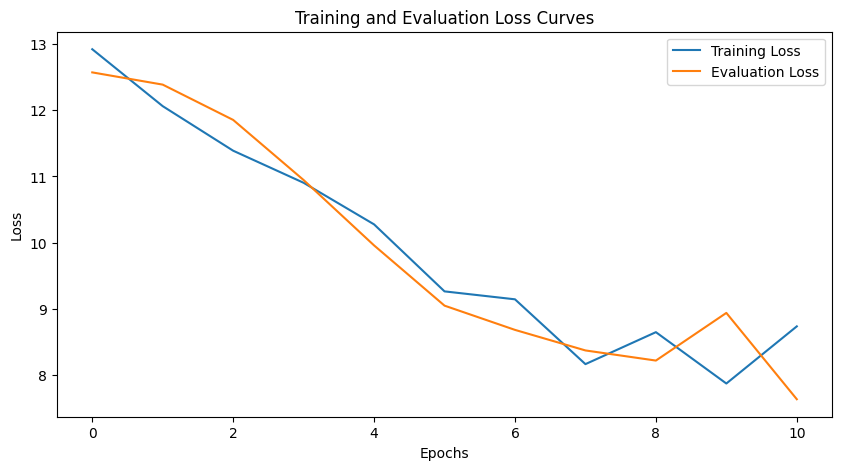

In [182]:
# Training
params = variables['params']

class TrainState(train_state.TrainState):
    key: jax.Array

state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    key=dropout_key,
    tx=optimizer
)

trained_model_state, train_losses, eval_losses = train(state=state, num_epochs=1000, dropout_key=dropout_key)

plot_loss_curves(train_losses, eval_losses)

In [179]:
import numpy as np
from flax.core import freeze, unfreeze
import json


def save_state_to_json(state, filename):
    # Convert JAX arrays to lists or numpy arrays
    state_dict = unfreeze(state.params)  # Convert FrozenDict to mutable dict
    
    # Recursively convert JAX arrays to lists
    def to_serializable(obj):
        if isinstance(obj, jnp.ndarray):
            return np.array(obj).tolist()
        elif isinstance(obj, dict):
            return {k: to_serializable(v) for k, v in obj.items()}
        else:
            return obj
    
    state_dict_serializable = to_serializable(state_dict)
    
    # Save to JSON file
    with open(filename, 'w') as f:
        json.dump(state_dict_serializable, f)
        

def load_state_from_json(filename, model, optimizer, key):
    # Load from JSON file
    with open(filename, 'r') as f:
        state_dict_serializable = json.load(f)
    
    # Recursively convert lists back to JAX arrays
    def to_jax_array(obj):
        if isinstance(obj, list):
            return jnp.array(obj)
        elif isinstance(obj, dict):
            return {k: to_jax_array(v) for k, v in obj.items()}
        else:
            return obj
    
    state_dict = to_jax_array(state_dict_serializable)
    
    # Recreate the TrainState
    state = TrainState.create(
        apply_fn=model.apply,
        params=freeze(state_dict),  # Convert back to FrozenDict
        key=key,
        tx=optimizer
    )
    
    return state


In [ ]:
# Save the trained model state
save_state_to_json(trained_model_state, 'trained_model_state.json')

In [180]:
# Load the trained model state
loaded_model_state = load_state_from_json('trained_model_state.json', model, optimizer, key)

In [181]:
# Generation

key, subkey, dropout_key = jax.random.split(key, num=3)

generated_seq = model.generate(
    key=subkey,
    params=loaded_model_state.params,
    data=jax.numpy.ones((1, 1), dtype=jax.numpy.int32),
    length=50
)
print(generated_seq)

decoded_text = tokenizer.decode(generated_seq[0])

print(decoded_text)

[[     1 151359 165199  89779 182603  65113  17489  47668  72077 166265
  164832 109466 119340 171449 130691 164410 127036 161637  79505  20081
  164099 100891 106072  12252  81930  12269    349 163517  61976  98804
  186850 100705 104446 129795  78952 107396 151227   6511 134519  27370
   48681   2665  46698 180812 174369 179076  95885  19206 193625  87915
  185376]]
" шоу vlan.bytes moons každ '-看片 ელ Pob persen_Player Torah tætşim рейтинг vento Kek하세요 controls combatirjado/typecrete mink�iv deceitmayaাঝ幕后avalt иҟоуп Rond selalu.invalidמנים்ட раскры ಮು methodology expect wholesale lunettes peate Typefaceต้น intens perguntar kolay ઑ
